# Energy Theft Detection

Time Series Data Analysis

Energy Theft Detection using image transformation technique and tiled convolutional neural network

Dataset : https://github.com/henryRDlab/ElectricityTheftDetection

[Reference]

1. Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks, ZhiguangWang and Tim Oates, Trajectory-Based Behavior Analytics: Papers from the 2015 AAAI Workshop, 2015.
2. Zibin Zheng, Yatao Yang, Xiangdong Niu, Hong-Ning Dai, Yuren Zhou, "Wide and Deep Convolutional Neural Networks for Electricity-Theft Detection to Secure Smart Grids", IEEE Transactions on Industrial Informatics,vol. 14, no. 4, pp. 1606-1615, April 2018 Publication year: 2018

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField, MarkovTransitionField

In [2]:
# Read data
df = pd.read_csv("data.csv", index_col=0)
df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,0.73,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15


In [3]:
# Check the ratio of 'FLAG' - 1: Abnormal(Energy Theft), 0: Normal
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

3615
0.08531577456811101


In [4]:
# Check missing values
print('Number of null values: {} ({}%)'.format(df.isnull().sum().sum(), 
                                             df.isnull().sum().sum() / (df.shape[0] * (df.shape[1]-1)) * 100 ))


Number of null values: 11233528 (25.639920234905684%)


In [5]:
# Check missing values for every customer (row)
print(df.isnull().sum(axis=1).sort_values(ascending=False) / df.shape[1])

CONS_NO
D176EB392233366F6F38E46AA592154E    0.999034
6BE983A5063B5DF9225ADD95AD3F241B    0.999034
2B981D4283253BA362DB2915358B88BF    0.999034
A63E94C418356023D70BE00B7FE2C4EE    0.999034
58C5C2F9D81EA5DC8421CACB0C73E495    0.999034
                                      ...   
13EE1FDD94A74F1739429DE62556A0CD    0.000966
85F57A0B8E99BF41F11343414AB8F99C    0.000966
427B07E41096C32AB26FCCC8F41DDFEC    0.000966
F1647D71CA98F7E352497203C8611E7E    0.000966
6602C0CE1EB77C772E294BB57564ECC6    0.000966
Length: 42372, dtype: float64


<Axes: xlabel='ratio of NA', ylabel='number of consumers'>

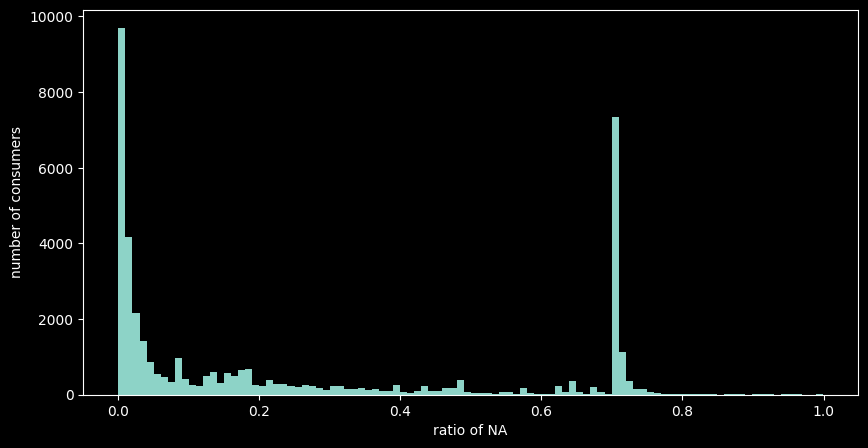

In [6]:
# Display histogram of the number of nulls in each row (across all columns)
na_ratio = df.isnull().sum(axis=1) / df.shape[1]
na_ratio.plot(kind='hist', xlabel='ratio of NA', ylabel='number of consumers', bins=100, figsize=(10, 5))


In [7]:
# Firstly, remove rows with more than 35 percent missing values
df = df[(df.isnull().sum(axis=1) / df.shape[1]) < 0.35]
print(df.shape)

(28949, 1035)


In [8]:
# check the customers with all 0 values
df[df.iloc[:, :-1].sum(axis=1) == 0.0]

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
B6E8F3547A23BF3F899ABEF08398EEF5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
680F35B3C0CB971083F4A8B543309FBB,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2920EB014F35BC4248F7255C85733472,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170537BAB9401C55116B6870089FDBF3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2CD0C1DC94E45E309324026357CACD4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072F101CD47D7DDA7DC42106617C456,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02D6FDF81EB86DD6EBE24E19C6F383E5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B99ED8A0093A11E875B6E5D538A4DB78,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='ratio of zero values', ylabel='number of consumers'>

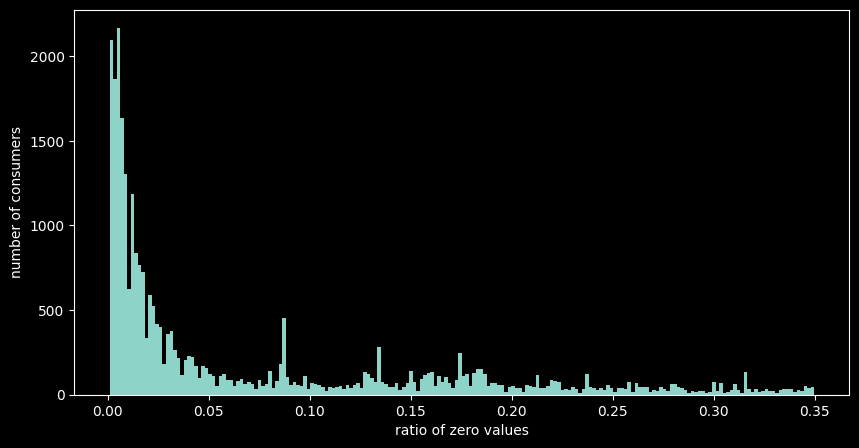

In [9]:
# Display histogram of the number of 0 values in each row (across all columns)
zero_ratio = df.isnull().sum(axis=1) / df.shape[1]
zero_ratio.plot(kind='hist', xlabel='ratio of zero values', ylabel='number of consumers', bins=200, figsize=(10, 5))

In [10]:
# Remove rows with more than 35 percent zero values (including nulls)
df = df[df.iloc[:, :-1].eq(0).sum(axis=1) / df.shape[1] < 0.35]
print(df.shape)

(23595, 1035)


In [11]:
# Check the ratio of 'FLAG' after cleansing
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

1911
0.08099173553719008


In [12]:
df_flag = df['FLAG']
df = df.drop(['FLAG'], axis=1)
df_flag

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    1
34C1954AA3703C4F8BD8EAEA7C4B7B83    1
768309B0EB11FD436CEE5ABFB84F4C0C    1
516954F5FF177CE314656D727FCC66A5    1
E34D1B467A365835A4A8AAD9395D49AA    1
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Name: FLAG, Length: 23595, dtype: int64

In [13]:
df = df.T
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,A9601F29D6AE4544F52BD5CB56426E3F,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,6.03,19.92,9.52,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-02,5.64,0.11,1.16,7.92,NaN,2.11,2.35,3.18,14.81,9.36,...,NaN,NaN,159.86,0.00,5.04,NaN,NaN,0.00,1.16,15.15
2014-01-03,6.99,0.25,0.75,8.41,NaN,1.69,2.56,3.33,13.11,11.21,...,NaN,NaN,157.20,0.00,4.92,NaN,NaN,0.00,0.92,19.28
2014-01-04,3.32,0.27,1.30,9.66,NaN,1.72,1.46,7.26,14.51,13.45,...,NaN,NaN,104.80,0.00,4.88,NaN,NaN,5.72,0.98,17.19
2014-01-05,3.61,0.21,0.74,9.86,NaN,1.31,2.04,6.36,15.43,12.20,...,NaN,NaN,118.17,0.00,13.59,NaN,NaN,6.05,1.54,16.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-27,6.73,1.18,3.82,57.22,4.59,12.22,15.89,0.00,11.65,9.68,...,8.60,11.85,236.22,2.50,6.78,0.82,2.83,4.64,0.51,11.15
2016-10-28,7.52,1.13,2.75,56.68,4.71,16.39,13.00,0.26,10.96,8.95,...,4.23,11.46,243.06,2.74,7.83,0.65,2.54,3.71,0.79,12.22
2016-10-29,10.89,1.34,2.96,45.28,5.62,12.14,14.80,0.45,13.34,8.51,...,3.54,8.98,114.47,4.55,14.42,0.53,3.40,6.22,0.66,13.16
2016-10-30,9.86,1.26,3.67,44.04,6.83,10.82,14.91,0.36,9.91,8.40,...,3.26,9.95,115.52,3.76,9.58,0.77,3.59,6.05,0.39,13.33


In [14]:
# interpolate residual null values
df.interpolate(limit_direction="both",inplace=True)

In [15]:
# check null values again
df.isnull().sum()

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    0
34C1954AA3703C4F8BD8EAEA7C4B7B83    0
768309B0EB11FD436CEE5ABFB84F4C0C    0
516954F5FF177CE314656D727FCC66A5    0
E34D1B467A365835A4A8AAD9395D49AA    0
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Length: 23595, dtype: int64

In [16]:
df = df.T
df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
CONS_NO,,,,,,,,,,,,,,,,,,,,,
EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
516954F5FF177CE314656D727FCC66A5,11.02,7.92,8.41,9.66,9.86,8.32,8.21,7.88,10.17,8.24,...,64.11,84.89,60.86,52.67,49.43,57.22,56.68,45.28,44.04,43.36
E34D1B467A365835A4A8AAD9395D49AA,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,...,6.27,6.47,3.99,5.03,5.28,4.59,4.71,5.62,6.83,4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5FCE503B6B616D5023B3C46173383107,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
F1472871E1AFF49D4289564B6377D76C,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77


In [17]:
df_all = pd.DataFrame.merge(df, df_flag, left_index=True, right_index=True)

### Under sampling

In [18]:
df_theft = df_all[df_all['FLAG'] == 1]
df_normal = df_all[df_all['FLAG'] == 0]

# Random sampling from df_normal with same size to df_theft for balancing
df_normal = df_normal.sample(n=df_theft.shape[0])

df_all = pd.concat([df_normal, df_theft])
df_all

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
8CCBFB60DCCC1158B2AAF61DE2E0C93B,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,1.15,...,5.87,4.49,4.13,6.92,4.90,6.00,4.16,6.69,5.44,0
A559BE78BDFCABA87329D2BB97D13A06,23.59,34.98,28.87,32.60,30.24,28.44,35.78,44.85,50.04,38.18,...,20.02,23.64,7.72,18.79,19.14,15.09,13.63,12.93,16.28,0
6410CD6A57A63EE1CC74DFFCC03F151B,3.74,3.23,3.47,4.57,3.96,3.36,3.28,3.34,3.40,4.10,...,3.19,3.39,3.07,2.65,3.06,2.92,3.52,2.62,3.37,0
5DB5F01A4B2857ECF17DCFFD0D4A3581,2.96,1.84,1.94,0.76,0.00,0.00,0.00,0.00,0.00,0.00,...,13.31,9.11,9.17,9.98,11.59,10.66,9.18,9.11,8.01,0
642952860C4F502047F6ECF8F2E4D127,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,8.34,5.24,5.71,5.84,4.74,5.76,4.93,4.46,7.11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41715691C8776A821E7656C05BC7326B,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,...,10.43,9.23,10.88,8.03,9.48,10.67,12.65,11.12,9.56,1
B7C5E0F9B8C258C21E4B925E67779313,37.67,46.66,37.28,41.33,38.91,31.15,66.65,32.01,36.85,94.06,...,0.63,0.62,0.61,0.62,0.61,0.61,0.60,0.60,0.59,1
B4998F95CB5A8A53C79C999C7179D00C,2.87,3.71,4.50,3.81,3.63,4.62,3.66,3.80,10.07,11.63,...,3.06,1.84,1.38,1.78,1.71,1.99,2.20,2.13,1.88,1


In [19]:
# Normalize data between 0 and 1
df_flag = df_all['FLAG']
df_all_scaled = df_all.div(df_all.max(axis=1), axis=0)
df_all_scaled['FLAG'] = df_flag
df_all_scaled

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
8CCBFB60DCCC1158B2AAF61DE2E0C93B,0.043760,0.043760,0.043760,0.043760,0.043760,0.043760,0.043760,0.043760,0.043760,0.043760,...,0.223364,0.170852,0.157154,0.263318,0.186454,0.228311,0.158295,0.254566,0.207002,0
A559BE78BDFCABA87329D2BB97D13A06,0.272213,0.403646,0.333141,0.376183,0.348950,0.328179,0.412878,0.517540,0.577429,0.440572,...,0.231018,0.272790,0.089084,0.216824,0.220863,0.174129,0.157281,0.149204,0.187861,0
6410CD6A57A63EE1CC74DFFCC03F151B,0.208589,0.180145,0.193530,0.254880,0.220859,0.187395,0.182934,0.186280,0.189626,0.228667,...,0.177914,0.189069,0.171221,0.147797,0.170664,0.162856,0.196319,0.146124,0.187953,0
5DB5F01A4B2857ECF17DCFFD0D4A3581,0.091641,0.056966,0.060062,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.412074,0.282043,0.283901,0.308978,0.358824,0.330031,0.284211,0.282043,0.247988,0
642952860C4F502047F6ECF8F2E4D127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.258204,0.162229,0.176780,0.180805,0.146749,0.178328,0.152632,0.138080,0.220124,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41715691C8776A821E7656C05BC7326B,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,...,0.121012,0.107089,0.126233,0.093166,0.109990,0.123796,0.146769,0.129017,0.110918,1
B7C5E0F9B8C258C21E4B925E67779313,0.267524,0.331369,0.264754,0.293516,0.276330,0.221220,0.473333,0.227328,0.261700,0.667992,...,0.004474,0.004403,0.004332,0.004403,0.004332,0.004332,0.004261,0.004261,0.004190,1
B4998F95CB5A8A53C79C999C7179D00C,0.064494,0.083371,0.101124,0.085618,0.081573,0.103820,0.082247,0.085393,0.226292,0.261348,...,0.068764,0.041348,0.031011,0.040000,0.038427,0.044719,0.049438,0.047865,0.042247,1


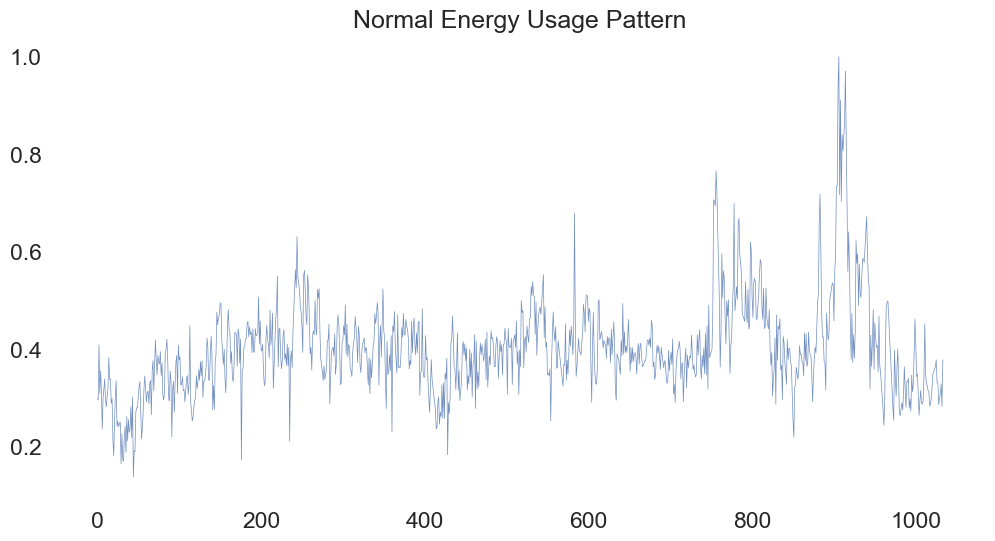

In [52]:
plt.grid()

for i in range(9,10):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==0].iloc[i,:-1], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('white') 
plt.gca().patch.set_alpha(0.9)
plt.title("Normal Energy Usage Pattern")
plt.grid(False)
# set size
plt.gcf().set_size_inches(12,6)
# background white
plt.show()

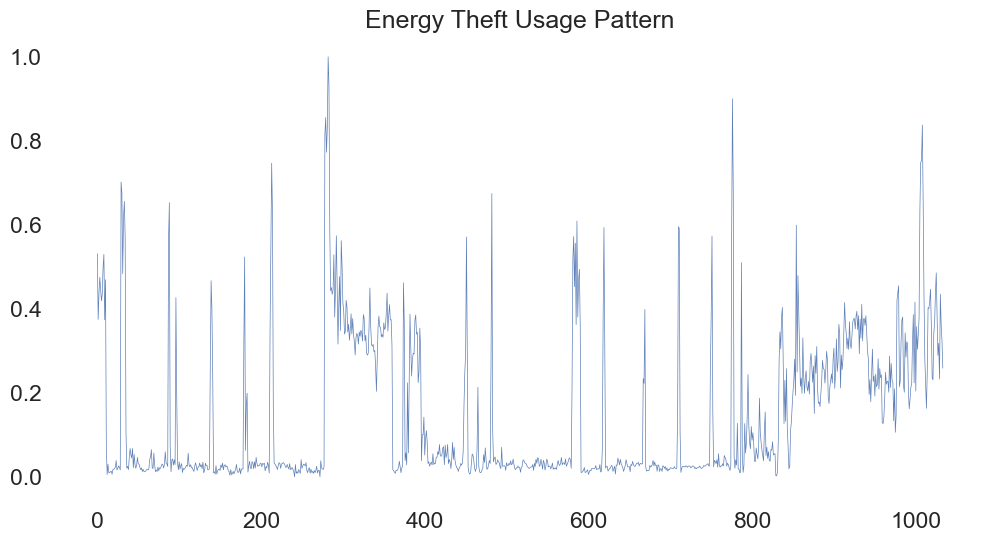

In [58]:
plt.grid()
for i in range(17,18):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==1].iloc[i,:-1], linewidth=0.5, alpha=0.9)

plt.gca().patch.set_facecolor('white') 
plt.title("Energy Theft Usage Pattern")
plt.gcf().set_size_inches(12,6)
plt.grid(False)
plt.show()

In [22]:
# Delete unnecessary variables to save memory
del df, df_flag, df_theft, df_normal, df_all

In [23]:
# Make images from time series using GramianAngularField and MarkovTransitionField
gaf = GramianAngularField(method='summation', image_size=224, sample_range=(-1,1))
gas = GramianAngularField(method='difference', image_size=224, sample_range=(-1,1))
mtf = MarkovTransitionField(image_size=224, n_bins = 2)

total = len(df_all_scaled)

# Create dataset to stroe the images
dataset = []

for i in tqdm(range(total)):
    # make 3 kinds of images(GAF, GAS, MTF) to build dataset witg 3 channels
    df_gaf = gaf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_gas = gas.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_mtf = mtf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')

    dataset.append((df_gaf, df_gas, df_mtf, df_all_scaled.iloc[i:i+1,-1:]))

100%|██████████| 3822/3822 [03:22<00:00, 18.86it/s]


C:\Users\kkomo\AppData\Local\Temp\ipykernel_48272\2951815641.py:8: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


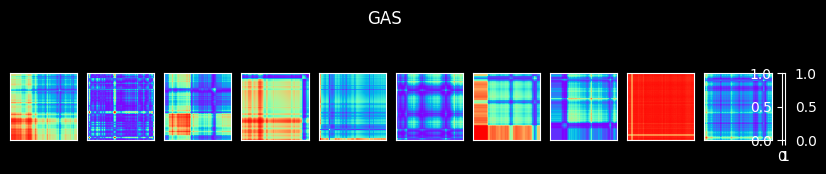

C:\Users\kkomo\AppData\Local\Temp\ipykernel_48272\2951815641.py:20: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


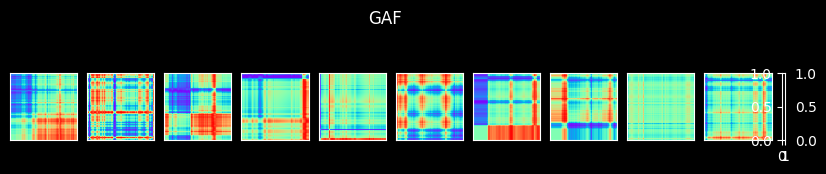

C:\Users\kkomo\AppData\Local\Temp\ipykernel_48272\2951815641.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


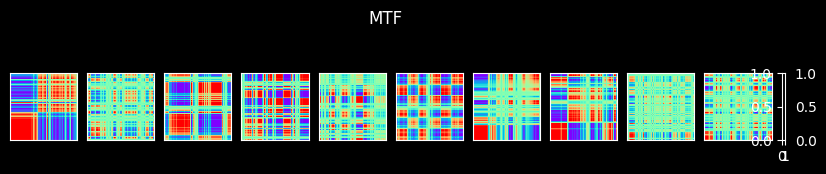

In [24]:
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][0][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAS")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][1][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAF")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][2][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("MTF")
plt.show()


In [25]:
# split train, test dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

splitter = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset = splitter[0]
test_dataset = splitter[1]

# split train, validation dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
splitter = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset = splitter[0]
val_dataset = splitter[1]

print("size (train, val, test) = ({}, {}, {})".format( len(train_dataset), len(val_dataset), len(test_dataset))) 

size (train, val, test) = (2445, 612, 765)


In [26]:
# Creating a cutomized dataset
class EnergyData(Dataset):
    def __init__(self, datalist):
        listx = []
        listy = []
        for i in datalist:
            # listx.append(torch.cat([i[0], i[1], i[2]]))
            listx.append(np.vstack((i[0], i[1], i[2])))
            
            if i[3].values == 0:
                y = torch.tensor([1,0])
                listy.append(y.float())
                # print('yes', y)
            else:
                y = torch.tensor([0,1])
                listy.append(y.float())
                # print('else', y)
            
            # listy.append(torch.unsqueeze(torch.tensor(i[1]).float(), dim=0))           
            
        self.x = listx
        self.y = listy
        self.len = len(datalist)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len


tr = EnergyData(train_dataset)
val = EnergyData(val_dataset)
ts = EnergyData(test_dataset)

del dataset

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device)) 

torch.manual_seed(45)
torch.cuda.manual_seed_all(45)

Using cuda device


In [28]:
def print_losses(train_counter, train_losses, val_counter, val_losses, weight_decay, lr_rate):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, label='Training Loss')
    plt.scatter(val_counter, val_losses, label='Validation Loss', color='red')
    plt.legend(['Training loss','Validation loss'], loc='upper right')
    plt.title('Training and Validation Loss(weight_decay = {}, lr = {})'.format(weight_decay, lr_rate))
    plt.ylabel('Binary Cross Entropy Loss')
    fig.show()

In [29]:
transform = transforms.Compose([#transforms.Resize(224),
                                #transforms.CenterCrop(224),
                                #transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

In [34]:
def train(model, tr_data, val_data, batch_size, lr_rate = 0.001, moment = 0.9, weight_dec = 0.08, num_of_epoch=10, logging_period=4):
    
    res_loss = {}
    
    class_weights = torch.Tensor([0.5, 0.5]).to(device)

    # Freeze model parameters except for the classifier
    for param in model.parameters():   
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    # List for plotting X-axis
    train_counter = []
    val_counter = []

    trainloader = DataLoader(tr_data, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    model.train()

    for epoch in tqdm(range(num_of_epoch), total=num_of_epoch):  # loop over the dataset multiple times

        epoch_loss = 0.0
        epoch_correct = 0    
        epoch_total = 0
        running_loss = 0.0   
        running_correct = 0 
        running_total = 0

        for i, data in enumerate(trainloader):  
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels =  data[0].to(device), data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            inputs = transform(inputs) # Added after submission (2024-04-04)
            outputs = model(inputs)   

            loss = criterion(outputs, labels)        
            loss.backward()
            optimizer.step()

            sum_loss = loss.item() * len(labels)
            running_loss += sum_loss
            epoch_loss += sum_loss

            num_correct = torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
            running_correct += num_correct
            epoch_correct += num_correct
            
            epoch_total = epoch_total + len(labels)
            running_total = running_total + len(labels)

            # print & accumulate training statistics (loss & accuracy) every 10 iterations
            if (i % logging_period == 0):            
                avg_running_loss = running_loss / running_total
                avg_running_accuracy = 100. * running_correct / running_total

                print('Epoch{} [{}/{} ({:.0f}%)]\t   avg.loss:{:.4f}   avg.accuracy:{:.4f}'
                    .format(epoch+1, i * len(labels), len(trainloader.dataset), 100. * i / len(trainloader), 
                            avg_running_loss, avg_running_accuracy))
                
                running_loss = 0.0   
                running_correct = 0 
                running_total = 0

                train_losses.append(avg_running_loss)
                train_accuracy.append(avg_running_accuracy)
                train_counter.append((epoch)*len(trainloader.dataset)+epoch_total)                

        # print & accumulate val statistics (loss & accuracy)
        print('[Epoch {}] Train Loss: {:.4f} Train Accuracy: {:.4f} w_decay:{} lr_rate:{}'.format(epoch + 1, 
                            epoch_loss / epoch_total, 100. * epoch_correct / epoch_total, weight_dec, lr_rate))

        # Validation at the end of the epoch
        # set mode to eval mode & tell torch no gradients are required.
        y_true = []
        y_pred = []

        model.eval()

        with torch.no_grad():   

            val_running_loss = 0.0
            val_correct = 0
            val_count = 0            

            # loop through the data and find accuracy and loss for all val data
            for (inputs, labels) in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                inputs = transform(inputs) # Added after submission (2024-04-04)
                outputs = model(inputs) 
                
                val_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()

                y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
                y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy

                loss = criterion(outputs, labels) 

                val_running_loss += loss.item() * len(labels)

                val_count = val_count + len(labels)      

        val_losses.append(val_running_loss / len(valloader.dataset))
        val_accuracy.append(100. * val_correct / len(valloader.dataset))
        val_counter.append((epoch+1) * len(trainloader.dataset))

        print('\nValidation set: avg.loss: {:.4f},   avg.accuracy: {}/{} ({:.4f}%)\n'.format(
        val_running_loss / len(valloader.dataset), val_correct, len(valloader.dataset), 100. * val_correct / len(valloader.dataset)))

        # Print F1 score
        rec_score = recall_score(y_true, y_pred)
        print('Recall: {:.6f}'.format(rec_score))

        pre_score = precision_score(y_true, y_pred)
        print('Precision: {:.6f}'.format(pre_score))

        f1 = f1_score(y_true, y_pred)
        print('F1 Score: {:.6f}'.format(f1))

        acc_score = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.6f}'.format(acc_score))        

        # set the model back to train mode
        model.train()

    # print('Finished Training')
    print_losses(train_counter, train_losses, val_counter, val_losses, weight_dec, lr_rate)

    res_loss[weight_dec] = val_running_loss / len(valloader.dataset)

    return f1

In [35]:
def test(model, ts, batch_size):

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        
        test_correct = 0

        testloader = DataLoader(ts, batch_size=batch_size)

        for (inputs, labels) in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = transform(inputs)  # Added after submission(2024-04-04)  
            outputs = model(inputs)
            
            test_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()

            y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy
                        
            accuracy_test = 100. * test_correct / len(testloader.dataset)

        # plot confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,6))
        sns.set(font_scale=1.5) # Added after submission(2024-04-04)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xticks([0, 1], ['Normal', 'Theft']) # Added after submission(2024-04-04)
        plt.yticks([0, 1], ['Normal', 'Theft']) # Added after submission(2024-04-04)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        # Print F1 score
        rec_score = recall_score(y_true, y_pred)
        print('Recall: {:.4f}'.format(rec_score))

        pre_score = precision_score(y_true, y_pred)
        print('Precision: {:.4f}'.format(pre_score))

        f1 = f1_score(y_true, y_pred)
        print('F1 Score: {:.4f}'.format(f1))

        acc_score = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.4f}'.format(acc_score))
    
    model.train()

    return

c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.001 ===================


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3682   avg.accuracy:50.0000
Epoch1 [128/2445 (5%)]	   avg.loss:0.3606   avg.accuracy:55.4688
Epoch1 [256/2445 (10%)]	   avg.loss:0.3630   avg.accuracy:46.8750
Epoch1 [384/2445 (16%)]	   avg.loss:0.3637   avg.accuracy:50.0000
Epoch1 [512/2445 (21%)]	   avg.loss:0.3624   avg.accuracy:49.2188
Epoch1 [640/2445 (26%)]	   avg.loss:0.3727   avg.accuracy:44.5312
Epoch1 [768/2445 (31%)]	   avg.loss:0.3670   avg.accuracy:49.2188
Epoch1 [896/2445 (36%)]	   avg.loss:0.3628   avg.accuracy:51.5625
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3576   avg.accuracy:50.7812
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3427   avg.accuracy:57.0312
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3379   avg.accuracy:57.8125
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3571   avg.accuracy:53.1250
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3371   avg.accuracy:58.5938
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3483   avg.accuracy:54.6875
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3632   avg.accuracy:53.9062
Epoch1 

  7%|▋         | 1/15 [00:17<04:02, 17.34s/it]


Validation set: avg.loss: 0.3533,   avg.accuracy: 320/612 (52.2876%)

Recall: 0.197531
Precision: 0.666667
F1 Score: 0.304762
Accuracy: 0.522876
Epoch2 [0/2445 (0%)]	   avg.loss:0.3694   avg.accuracy:56.2500
Epoch2 [128/2445 (5%)]	   avg.loss:0.3533   avg.accuracy:52.3438
Epoch2 [256/2445 (10%)]	   avg.loss:0.3284   avg.accuracy:60.1562
Epoch2 [384/2445 (16%)]	   avg.loss:0.3697   avg.accuracy:51.5625
Epoch2 [512/2445 (21%)]	   avg.loss:0.3445   avg.accuracy:57.8125
Epoch2 [640/2445 (26%)]	   avg.loss:0.3379   avg.accuracy:60.1562
Epoch2 [768/2445 (31%)]	   avg.loss:0.3482   avg.accuracy:53.9062
Epoch2 [896/2445 (36%)]	   avg.loss:0.3377   avg.accuracy:60.9375
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3250   avg.accuracy:64.0625
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3273   avg.accuracy:65.6250
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3451   avg.accuracy:54.6875
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3341   avg.accuracy:60.1562
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3465   avg.accuracy:57.

 13%|█▎        | 2/15 [00:34<03:41, 17.05s/it]


Validation set: avg.loss: 0.3311,   avg.accuracy: 375/612 (61.2745%)

Recall: 0.512346
Precision: 0.677551
F1 Score: 0.583480
Accuracy: 0.612745
Epoch3 [0/2445 (0%)]	   avg.loss:0.3881   avg.accuracy:43.7500
Epoch3 [128/2445 (5%)]	   avg.loss:0.3392   avg.accuracy:58.5938
Epoch3 [256/2445 (10%)]	   avg.loss:0.3387   avg.accuracy:58.5938
Epoch3 [384/2445 (16%)]	   avg.loss:0.3430   avg.accuracy:55.4688
Epoch3 [512/2445 (21%)]	   avg.loss:0.3480   avg.accuracy:53.1250
Epoch3 [640/2445 (26%)]	   avg.loss:0.3361   avg.accuracy:61.7188
Epoch3 [768/2445 (31%)]	   avg.loss:0.3078   avg.accuracy:68.7500
Epoch3 [896/2445 (36%)]	   avg.loss:0.3119   avg.accuracy:66.4062
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3285   avg.accuracy:59.3750
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3414   avg.accuracy:56.2500
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3217   avg.accuracy:62.5000
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3345   avg.accuracy:57.0312
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3165   avg.accuracy:64.

 20%|██        | 3/15 [00:51<03:24, 17.07s/it]


Validation set: avg.loss: 0.3223,   avg.accuracy: 393/612 (64.2157%)

Recall: 0.663580
Precision: 0.661538
F1 Score: 0.662558
Accuracy: 0.642157
Epoch4 [0/2445 (0%)]	   avg.loss:0.3566   avg.accuracy:53.1250
Epoch4 [128/2445 (5%)]	   avg.loss:0.3381   avg.accuracy:57.0312
Epoch4 [256/2445 (10%)]	   avg.loss:0.3359   avg.accuracy:57.8125
Epoch4 [384/2445 (16%)]	   avg.loss:0.3323   avg.accuracy:57.8125
Epoch4 [512/2445 (21%)]	   avg.loss:0.3154   avg.accuracy:64.8438
Epoch4 [640/2445 (26%)]	   avg.loss:0.3233   avg.accuracy:62.5000
Epoch4 [768/2445 (31%)]	   avg.loss:0.3410   avg.accuracy:58.5938
Epoch4 [896/2445 (36%)]	   avg.loss:0.3383   avg.accuracy:59.3750
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3155   avg.accuracy:67.1875
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3213   avg.accuracy:58.5938
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3246   avg.accuracy:63.2812
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3119   avg.accuracy:71.0938
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3383   avg.accuracy:56.

 27%|██▋       | 4/15 [01:08<03:09, 17.21s/it]


Validation set: avg.loss: 0.3217,   avg.accuracy: 394/612 (64.3791%)

Recall: 0.632716
Precision: 0.674342
F1 Score: 0.652866
Accuracy: 0.643791
Epoch5 [0/2445 (0%)]	   avg.loss:0.2949   avg.accuracy:71.8750
Epoch5 [128/2445 (5%)]	   avg.loss:0.3247   avg.accuracy:63.2812
Epoch5 [256/2445 (10%)]	   avg.loss:0.3304   avg.accuracy:60.9375
Epoch5 [384/2445 (16%)]	   avg.loss:0.3230   avg.accuracy:64.8438
Epoch5 [512/2445 (21%)]	   avg.loss:0.3238   avg.accuracy:64.0625
Epoch5 [640/2445 (26%)]	   avg.loss:0.3035   avg.accuracy:71.0938
Epoch5 [768/2445 (31%)]	   avg.loss:0.3404   avg.accuracy:55.4688
Epoch5 [896/2445 (36%)]	   avg.loss:0.3217   avg.accuracy:60.9375
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3138   avg.accuracy:63.2812
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3408   avg.accuracy:54.6875
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3157   avg.accuracy:67.1875
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3269   avg.accuracy:66.4062
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3293   avg.accuracy:63.

 33%|███▎      | 5/15 [01:25<02:50, 17.00s/it]


Validation set: avg.loss: 0.3191,   avg.accuracy: 404/612 (66.0131%)

Recall: 0.709877
Precision: 0.668605
F1 Score: 0.688623
Accuracy: 0.660131
Epoch6 [0/2445 (0%)]	   avg.loss:0.3338   avg.accuracy:62.5000
Epoch6 [128/2445 (5%)]	   avg.loss:0.3242   avg.accuracy:61.7188
Epoch6 [256/2445 (10%)]	   avg.loss:0.3220   avg.accuracy:64.8438
Epoch6 [384/2445 (16%)]	   avg.loss:0.3281   avg.accuracy:57.8125
Epoch6 [512/2445 (21%)]	   avg.loss:0.3104   avg.accuracy:67.9688
Epoch6 [640/2445 (26%)]	   avg.loss:0.3285   avg.accuracy:62.5000
Epoch6 [768/2445 (31%)]	   avg.loss:0.3178   avg.accuracy:65.6250
Epoch6 [896/2445 (36%)]	   avg.loss:0.3108   avg.accuracy:67.1875
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3204   avg.accuracy:61.7188
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3047   avg.accuracy:69.5312
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3305   avg.accuracy:58.5938
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3250   avg.accuracy:60.9375
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3260   avg.accuracy:60.

 40%|████      | 6/15 [01:41<02:31, 16.79s/it]


Validation set: avg.loss: 0.3178,   avg.accuracy: 396/612 (64.7059%)

Recall: 0.722222
Precision: 0.650000
F1 Score: 0.684211
Accuracy: 0.647059
Epoch7 [0/2445 (0%)]	   avg.loss:0.2640   avg.accuracy:87.5000
Epoch7 [128/2445 (5%)]	   avg.loss:0.3228   avg.accuracy:64.0625
Epoch7 [256/2445 (10%)]	   avg.loss:0.3184   avg.accuracy:64.8438
Epoch7 [384/2445 (16%)]	   avg.loss:0.3132   avg.accuracy:65.6250
Epoch7 [512/2445 (21%)]	   avg.loss:0.3193   avg.accuracy:64.8438
Epoch7 [640/2445 (26%)]	   avg.loss:0.3316   avg.accuracy:60.1562
Epoch7 [768/2445 (31%)]	   avg.loss:0.3186   avg.accuracy:63.2812
Epoch7 [896/2445 (36%)]	   avg.loss:0.3168   avg.accuracy:68.7500
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3177   avg.accuracy:64.8438
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3135   avg.accuracy:64.8438
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3225   avg.accuracy:64.0625
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3153   avg.accuracy:65.6250
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3298   avg.accuracy:62.

 47%|████▋     | 7/15 [01:58<02:13, 16.72s/it]


Validation set: avg.loss: 0.3207,   avg.accuracy: 398/612 (65.0327%)

Recall: 0.583333
Precision: 0.705224
F1 Score: 0.638514
Accuracy: 0.650327
Epoch8 [0/2445 (0%)]	   avg.loss:0.3102   avg.accuracy:65.6250
Epoch8 [128/2445 (5%)]	   avg.loss:0.3071   avg.accuracy:68.7500
Epoch8 [256/2445 (10%)]	   avg.loss:0.3147   avg.accuracy:64.0625
Epoch8 [384/2445 (16%)]	   avg.loss:0.3133   avg.accuracy:68.7500
Epoch8 [512/2445 (21%)]	   avg.loss:0.3258   avg.accuracy:64.0625
Epoch8 [640/2445 (26%)]	   avg.loss:0.2945   avg.accuracy:75.0000
Epoch8 [768/2445 (31%)]	   avg.loss:0.3180   avg.accuracy:64.8438
Epoch8 [896/2445 (36%)]	   avg.loss:0.3122   avg.accuracy:67.1875
Epoch8 [1024/2445 (42%)]	   avg.loss:0.2969   avg.accuracy:74.2188
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3138   avg.accuracy:64.0625
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3229   avg.accuracy:62.5000
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3155   avg.accuracy:67.1875
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3069   avg.accuracy:67.

 53%|█████▎    | 8/15 [02:15<01:58, 16.90s/it]


Validation set: avg.loss: 0.3153,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.734568
Precision: 0.662953
F1 Score: 0.696925
Accuracy: 0.661765
Epoch9 [0/2445 (0%)]	   avg.loss:0.3298   avg.accuracy:59.3750
Epoch9 [128/2445 (5%)]	   avg.loss:0.3219   avg.accuracy:64.0625
Epoch9 [256/2445 (10%)]	   avg.loss:0.3110   avg.accuracy:69.5312
Epoch9 [384/2445 (16%)]	   avg.loss:0.2881   avg.accuracy:74.2188
Epoch9 [512/2445 (21%)]	   avg.loss:0.3180   avg.accuracy:66.4062
Epoch9 [640/2445 (26%)]	   avg.loss:0.3023   avg.accuracy:67.9688
Epoch9 [768/2445 (31%)]	   avg.loss:0.3363   avg.accuracy:57.8125
Epoch9 [896/2445 (36%)]	   avg.loss:0.3328   avg.accuracy:56.2500
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3007   avg.accuracy:70.3125
Epoch9 [1152/2445 (47%)]	   avg.loss:0.2997   avg.accuracy:73.4375
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3152   avg.accuracy:64.0625
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3230   avg.accuracy:60.1562
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3009   avg.accuracy:70.

 60%|██████    | 9/15 [02:32<01:41, 16.92s/it]


Validation set: avg.loss: 0.3150,   avg.accuracy: 407/612 (66.5033%)

Recall: 0.709877
Precision: 0.674487
F1 Score: 0.691729
Accuracy: 0.665033
Epoch10 [0/2445 (0%)]	   avg.loss:0.3252   avg.accuracy:62.5000
Epoch10 [128/2445 (5%)]	   avg.loss:0.2995   avg.accuracy:69.5312
Epoch10 [256/2445 (10%)]	   avg.loss:0.3023   avg.accuracy:67.9688
Epoch10 [384/2445 (16%)]	   avg.loss:0.3162   avg.accuracy:64.8438
Epoch10 [512/2445 (21%)]	   avg.loss:0.3219   avg.accuracy:66.4062
Epoch10 [640/2445 (26%)]	   avg.loss:0.3254   avg.accuracy:65.6250
Epoch10 [768/2445 (31%)]	   avg.loss:0.3177   avg.accuracy:64.8438
Epoch10 [896/2445 (36%)]	   avg.loss:0.2990   avg.accuracy:71.8750
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3102   avg.accuracy:68.7500
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3158   avg.accuracy:65.6250
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3084   avg.accuracy:66.4062
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3140   avg.accuracy:64.8438
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3028   avg

 67%|██████▋   | 10/15 [02:49<01:24, 16.93s/it]


Validation set: avg.loss: 0.3141,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.771605
Precision: 0.652742
F1 Score: 0.707214
Accuracy: 0.661765
Epoch11 [0/2445 (0%)]	   avg.loss:0.2972   avg.accuracy:78.1250
Epoch11 [128/2445 (5%)]	   avg.loss:0.3110   avg.accuracy:69.5312
Epoch11 [256/2445 (10%)]	   avg.loss:0.3114   avg.accuracy:64.8438
Epoch11 [384/2445 (16%)]	   avg.loss:0.3061   avg.accuracy:68.7500
Epoch11 [512/2445 (21%)]	   avg.loss:0.2942   avg.accuracy:71.0938
Epoch11 [640/2445 (26%)]	   avg.loss:0.3047   avg.accuracy:67.9688
Epoch11 [768/2445 (31%)]	   avg.loss:0.3075   avg.accuracy:65.6250
Epoch11 [896/2445 (36%)]	   avg.loss:0.3125   avg.accuracy:68.7500
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3195   avg.accuracy:67.1875
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3176   avg.accuracy:60.9375
Epoch11 [1280/2445 (52%)]	   avg.loss:0.2971   avg.accuracy:78.1250
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3159   avg.accuracy:62.5000
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3123   avg

 73%|███████▎  | 11/15 [03:06<01:07, 16.98s/it]


Validation set: avg.loss: 0.3137,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.756173
Precision: 0.665761
F1 Score: 0.708092
Accuracy: 0.669935
Epoch12 [0/2445 (0%)]	   avg.loss:0.2738   avg.accuracy:84.3750
Epoch12 [128/2445 (5%)]	   avg.loss:0.2996   avg.accuracy:72.6562
Epoch12 [256/2445 (10%)]	   avg.loss:0.3315   avg.accuracy:62.5000
Epoch12 [384/2445 (16%)]	   avg.loss:0.2887   avg.accuracy:75.0000
Epoch12 [512/2445 (21%)]	   avg.loss:0.3051   avg.accuracy:71.0938
Epoch12 [640/2445 (26%)]	   avg.loss:0.3025   avg.accuracy:72.6562
Epoch12 [768/2445 (31%)]	   avg.loss:0.3128   avg.accuracy:67.1875
Epoch12 [896/2445 (36%)]	   avg.loss:0.2893   avg.accuracy:75.0000
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3149   avg.accuracy:65.6250
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3069   avg.accuracy:66.4062
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3284   avg.accuracy:60.1562
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3183   avg.accuracy:67.1875
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3278   avg

 80%|████████  | 12/15 [03:23<00:51, 17.09s/it]


Validation set: avg.loss: 0.3130,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.740741
Precision: 0.668524
F1 Score: 0.702782
Accuracy: 0.668301
Epoch13 [0/2445 (0%)]	   avg.loss:0.3145   avg.accuracy:68.7500
Epoch13 [128/2445 (5%)]	   avg.loss:0.2880   avg.accuracy:76.5625
Epoch13 [256/2445 (10%)]	   avg.loss:0.3016   avg.accuracy:71.0938
Epoch13 [384/2445 (16%)]	   avg.loss:0.2830   avg.accuracy:77.3438
Epoch13 [512/2445 (21%)]	   avg.loss:0.3280   avg.accuracy:57.0312
Epoch13 [640/2445 (26%)]	   avg.loss:0.2907   avg.accuracy:75.7812
Epoch13 [768/2445 (31%)]	   avg.loss:0.3003   avg.accuracy:71.8750
Epoch13 [896/2445 (36%)]	   avg.loss:0.3213   avg.accuracy:61.7188
Epoch13 [1024/2445 (42%)]	   avg.loss:0.2887   avg.accuracy:77.3438
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3006   avg.accuracy:71.8750
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3067   avg.accuracy:67.9688
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3294   avg.accuracy:59.3750
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3165   avg

 87%|████████▋ | 13/15 [03:41<00:34, 17.08s/it]


Validation set: avg.loss: 0.3182,   avg.accuracy: 397/612 (64.8693%)

Recall: 0.564815
Precision: 0.712062
F1 Score: 0.629948
Accuracy: 0.648693
Epoch14 [0/2445 (0%)]	   avg.loss:0.3069   avg.accuracy:71.8750
Epoch14 [128/2445 (5%)]	   avg.loss:0.3059   avg.accuracy:67.1875
Epoch14 [256/2445 (10%)]	   avg.loss:0.3132   avg.accuracy:69.5312
Epoch14 [384/2445 (16%)]	   avg.loss:0.3073   avg.accuracy:67.1875
Epoch14 [512/2445 (21%)]	   avg.loss:0.2927   avg.accuracy:74.2188
Epoch14 [640/2445 (26%)]	   avg.loss:0.3002   avg.accuracy:69.5312
Epoch14 [768/2445 (31%)]	   avg.loss:0.3162   avg.accuracy:67.1875
Epoch14 [896/2445 (36%)]	   avg.loss:0.2951   avg.accuracy:75.0000
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3077   avg.accuracy:69.5312
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3195   avg.accuracy:62.5000
Epoch14 [1280/2445 (52%)]	   avg.loss:0.2982   avg.accuracy:71.8750
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3152   avg.accuracy:68.7500
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3061   avg

 93%|█████████▎| 14/15 [03:57<00:17, 17.05s/it]


Validation set: avg.loss: 0.3128,   avg.accuracy: 408/612 (66.6667%)

Recall: 0.787037
Precision: 0.653846
F1 Score: 0.714286
Accuracy: 0.666667
Epoch15 [0/2445 (0%)]	   avg.loss:0.3052   avg.accuracy:68.7500
Epoch15 [128/2445 (5%)]	   avg.loss:0.3230   avg.accuracy:60.1562
Epoch15 [256/2445 (10%)]	   avg.loss:0.3009   avg.accuracy:67.9688
Epoch15 [384/2445 (16%)]	   avg.loss:0.3124   avg.accuracy:64.8438
Epoch15 [512/2445 (21%)]	   avg.loss:0.3015   avg.accuracy:72.6562
Epoch15 [640/2445 (26%)]	   avg.loss:0.3008   avg.accuracy:65.6250
Epoch15 [768/2445 (31%)]	   avg.loss:0.3000   avg.accuracy:71.8750
Epoch15 [896/2445 (36%)]	   avg.loss:0.2920   avg.accuracy:68.7500
Epoch15 [1024/2445 (42%)]	   avg.loss:0.2927   avg.accuracy:77.3438
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3164   avg.accuracy:67.1875
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3139   avg.accuracy:66.4062
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3060   avg.accuracy:72.6562
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3118   avg

100%|██████████| 15/15 [04:15<00:00, 17.00s/it]


Validation set: avg.loss: 0.3119,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.728395
Precision: 0.672365
F1 Score: 0.699259
Accuracy: 0.668301
{0.001: 0.6992592592592592}



C:\Users\kkomo\AppData\Local\Temp\ipykernel_48272\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


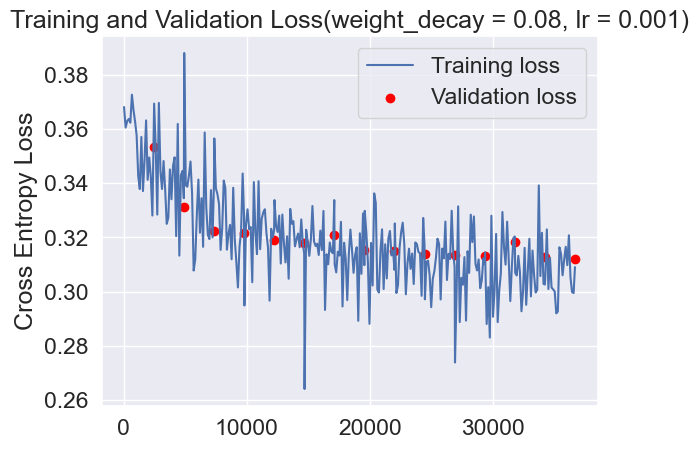

In [36]:
%matplotlib inline

lr_rate = [0.0005, 0.001, 0.0015, 0.002]
moment = 0.9
weight_dec = 0.08
num_of_epoch = 15
batch_size = 32
logging_period = 4

result_list = {}

for lr in lr_rate:

    model =  models.vgg16(pretrained=True)

    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),        
        nn.Softmax(dim=1)
    )

    print('===================  Weight decay = {}, lr = {} ==================='.format(weight_dec, lr))    
    result_list[lr] = train( model, tr, val, batch_size, lr, moment, weight_dec, num_of_epoch, logging_period)

print(result_list)


c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3502   avg.accuracy:56.2500
Epoch1 [128/2445 (5%)]	   avg.loss:0.3618   avg.accuracy:54.6875
Epoch1 [256/2445 (10%)]	   avg.loss:0.3628   avg.accuracy:50.0000
Epoch1 [384/2445 (16%)]	   avg.loss:0.3551   avg.accuracy:52.3438
Epoch1 [512/2445 (21%)]	   avg.loss:0.3532   avg.accuracy:53.1250
Epoch1 [640/2445 (26%)]	   avg.loss:0.3448   avg.accuracy:56.2500
Epoch1 [768/2445 (31%)]	   avg.loss:0.3498   avg.accuracy:55.4688
Epoch1 [896/2445 (36%)]	   avg.loss:0.3469   avg.accuracy:53.1250
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3362   avg.accuracy:57.0312
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3503   avg.accuracy:47.6562
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3429   avg.accuracy:58.5938
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3341   avg.accuracy:59.3750
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3418   avg.accuracy:54.6875
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3422   avg.accuracy:53.9062
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3453   avg.accuracy:55.4688
Epoch1 

  7%|▋         | 1/15 [00:30<07:03, 30.28s/it]


Validation set: avg.loss: 0.3283,   avg.accuracy: 380/612 (62.0915%)

Recall: 0.660494
Precision: 0.636905
F1 Score: 0.648485
Accuracy: 0.620915
Epoch2 [0/2445 (0%)]	   avg.loss:0.3371   avg.accuracy:62.5000
Epoch2 [128/2445 (5%)]	   avg.loss:0.3421   avg.accuracy:57.8125
Epoch2 [256/2445 (10%)]	   avg.loss:0.3329   avg.accuracy:60.9375
Epoch2 [384/2445 (16%)]	   avg.loss:0.3414   avg.accuracy:53.9062
Epoch2 [512/2445 (21%)]	   avg.loss:0.3373   avg.accuracy:57.8125
Epoch2 [640/2445 (26%)]	   avg.loss:0.3480   avg.accuracy:57.8125
Epoch2 [768/2445 (31%)]	   avg.loss:0.3408   avg.accuracy:53.9062
Epoch2 [896/2445 (36%)]	   avg.loss:0.3545   avg.accuracy:54.6875
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3267   avg.accuracy:62.5000
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3346   avg.accuracy:60.9375
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3260   avg.accuracy:67.1875
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3214   avg.accuracy:62.5000
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3220   avg.accuracy:62.

 13%|█▎        | 2/15 [00:59<06:26, 29.76s/it]


Validation set: avg.loss: 0.3229,   avg.accuracy: 391/612 (63.8889%)

Recall: 0.675926
Precision: 0.653731
F1 Score: 0.664643
Accuracy: 0.638889
Epoch3 [0/2445 (0%)]	   avg.loss:0.3330   avg.accuracy:56.2500
Epoch3 [128/2445 (5%)]	   avg.loss:0.3381   avg.accuracy:61.7188
Epoch3 [256/2445 (10%)]	   avg.loss:0.3028   avg.accuracy:64.8438
Epoch3 [384/2445 (16%)]	   avg.loss:0.3042   avg.accuracy:68.7500
Epoch3 [512/2445 (21%)]	   avg.loss:0.3148   avg.accuracy:65.6250
Epoch3 [640/2445 (26%)]	   avg.loss:0.3058   avg.accuracy:69.5312
Epoch3 [768/2445 (31%)]	   avg.loss:0.3146   avg.accuracy:66.4062
Epoch3 [896/2445 (36%)]	   avg.loss:0.3108   avg.accuracy:64.8438
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3053   avg.accuracy:69.5312
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3284   avg.accuracy:60.9375
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3255   avg.accuracy:61.7188
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3088   avg.accuracy:68.7500
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3161   avg.accuracy:63.

 20%|██        | 3/15 [01:28<05:50, 29.17s/it]


Validation set: avg.loss: 0.3327,   avg.accuracy: 366/612 (59.8039%)

Recall: 0.407407
Precision: 0.709677
F1 Score: 0.517647
Accuracy: 0.598039
Epoch4 [0/2445 (0%)]	   avg.loss:0.3407   avg.accuracy:59.3750
Epoch4 [128/2445 (5%)]	   avg.loss:0.3357   avg.accuracy:64.8438
Epoch4 [256/2445 (10%)]	   avg.loss:0.3311   avg.accuracy:58.5938
Epoch4 [384/2445 (16%)]	   avg.loss:0.3284   avg.accuracy:61.7188
Epoch4 [512/2445 (21%)]	   avg.loss:0.3432   avg.accuracy:54.6875
Epoch4 [640/2445 (26%)]	   avg.loss:0.3153   avg.accuracy:60.9375
Epoch4 [768/2445 (31%)]	   avg.loss:0.3044   avg.accuracy:68.7500
Epoch4 [896/2445 (36%)]	   avg.loss:0.3180   avg.accuracy:64.0625
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3258   avg.accuracy:61.7188
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3118   avg.accuracy:66.4062
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3295   avg.accuracy:64.8438
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3054   avg.accuracy:68.7500
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3115   avg.accuracy:64.

 27%|██▋       | 4/15 [01:56<05:15, 28.71s/it]


Validation set: avg.loss: 0.3178,   avg.accuracy: 398/612 (65.0327%)

Recall: 0.737654
Precision: 0.649457
F1 Score: 0.690751
Accuracy: 0.650327
Epoch5 [0/2445 (0%)]	   avg.loss:0.2897   avg.accuracy:81.2500
Epoch5 [128/2445 (5%)]	   avg.loss:0.3190   avg.accuracy:64.0625
Epoch5 [256/2445 (10%)]	   avg.loss:0.3165   avg.accuracy:67.1875
Epoch5 [384/2445 (16%)]	   avg.loss:0.2979   avg.accuracy:68.7500
Epoch5 [512/2445 (21%)]	   avg.loss:0.3225   avg.accuracy:61.7188
Epoch5 [640/2445 (26%)]	   avg.loss:0.2974   avg.accuracy:72.6562
Epoch5 [768/2445 (31%)]	   avg.loss:0.3244   avg.accuracy:60.1562
Epoch5 [896/2445 (36%)]	   avg.loss:0.3340   avg.accuracy:60.1562
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3114   avg.accuracy:66.4062
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3111   avg.accuracy:65.6250
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3193   avg.accuracy:64.8438
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3017   avg.accuracy:70.3125
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3168   avg.accuracy:63.

 33%|███▎      | 5/15 [02:23<04:43, 28.37s/it]


Validation set: avg.loss: 0.3169,   avg.accuracy: 400/612 (65.3595%)

Recall: 0.799383
Precision: 0.637931
F1 Score: 0.709589
Accuracy: 0.653595
Epoch6 [0/2445 (0%)]	   avg.loss:0.3257   avg.accuracy:65.6250
Epoch6 [128/2445 (5%)]	   avg.loss:0.3372   avg.accuracy:57.8125
Epoch6 [256/2445 (10%)]	   avg.loss:0.3048   avg.accuracy:69.5312
Epoch6 [384/2445 (16%)]	   avg.loss:0.3153   avg.accuracy:63.2812
Epoch6 [512/2445 (21%)]	   avg.loss:0.3342   avg.accuracy:57.8125
Epoch6 [640/2445 (26%)]	   avg.loss:0.3125   avg.accuracy:63.2812
Epoch6 [768/2445 (31%)]	   avg.loss:0.3108   avg.accuracy:65.6250
Epoch6 [896/2445 (36%)]	   avg.loss:0.3066   avg.accuracy:67.9688
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3138   avg.accuracy:67.1875
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3118   avg.accuracy:70.3125
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3276   avg.accuracy:60.9375
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3060   avg.accuracy:71.0938
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3143   avg.accuracy:64.

 40%|████      | 6/15 [02:52<04:16, 28.55s/it]


Validation set: avg.loss: 0.3160,   avg.accuracy: 402/612 (65.6863%)

Recall: 0.793210
Precision: 0.642500
F1 Score: 0.709945
Accuracy: 0.656863
Epoch7 [0/2445 (0%)]	   avg.loss:0.3039   avg.accuracy:65.6250
Epoch7 [128/2445 (5%)]	   avg.loss:0.3218   avg.accuracy:60.9375
Epoch7 [256/2445 (10%)]	   avg.loss:0.3084   avg.accuracy:67.9688
Epoch7 [384/2445 (16%)]	   avg.loss:0.3107   avg.accuracy:70.3125
Epoch7 [512/2445 (21%)]	   avg.loss:0.3153   avg.accuracy:61.7188
Epoch7 [640/2445 (26%)]	   avg.loss:0.3090   avg.accuracy:68.7500
Epoch7 [768/2445 (31%)]	   avg.loss:0.3030   avg.accuracy:67.1875
Epoch7 [896/2445 (36%)]	   avg.loss:0.3146   avg.accuracy:64.0625
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3052   avg.accuracy:66.4062
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3021   avg.accuracy:69.5312
Epoch7 [1280/2445 (52%)]	   avg.loss:0.2971   avg.accuracy:72.6562
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3121   avg.accuracy:64.8438
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3206   avg.accuracy:62.

 47%|████▋     | 7/15 [03:20<03:45, 28.22s/it]


Validation set: avg.loss: 0.3144,   avg.accuracy: 404/612 (66.0131%)

Recall: 0.753086
Precision: 0.655914
F1 Score: 0.701149
Accuracy: 0.660131
Epoch8 [0/2445 (0%)]	   avg.loss:0.3048   avg.accuracy:68.7500
Epoch8 [128/2445 (5%)]	   avg.loss:0.2965   avg.accuracy:73.4375
Epoch8 [256/2445 (10%)]	   avg.loss:0.3093   avg.accuracy:67.1875
Epoch8 [384/2445 (16%)]	   avg.loss:0.3323   avg.accuracy:58.5938
Epoch8 [512/2445 (21%)]	   avg.loss:0.3078   avg.accuracy:68.7500
Epoch8 [640/2445 (26%)]	   avg.loss:0.3070   avg.accuracy:65.6250
Epoch8 [768/2445 (31%)]	   avg.loss:0.3031   avg.accuracy:72.6562
Epoch8 [896/2445 (36%)]	   avg.loss:0.2942   avg.accuracy:74.2188
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3037   avg.accuracy:73.4375
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3240   avg.accuracy:59.3750
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3154   avg.accuracy:64.8438
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3116   avg.accuracy:66.4062
Epoch8 [1536/2445 (62%)]	   avg.loss:0.2949   avg.accuracy:71.

 53%|█████▎    | 8/15 [03:47<03:16, 28.01s/it]


Validation set: avg.loss: 0.3189,   avg.accuracy: 397/612 (64.8693%)

Recall: 0.583333
Precision: 0.702602
F1 Score: 0.637437
Accuracy: 0.648693
Epoch9 [0/2445 (0%)]	   avg.loss:0.3449   avg.accuracy:59.3750
Epoch9 [128/2445 (5%)]	   avg.loss:0.2954   avg.accuracy:72.6562
Epoch9 [256/2445 (10%)]	   avg.loss:0.3137   avg.accuracy:64.8438
Epoch9 [384/2445 (16%)]	   avg.loss:0.3105   avg.accuracy:71.0938
Epoch9 [512/2445 (21%)]	   avg.loss:0.2932   avg.accuracy:74.2188
Epoch9 [640/2445 (26%)]	   avg.loss:0.3275   avg.accuracy:61.7188
Epoch9 [768/2445 (31%)]	   avg.loss:0.3179   avg.accuracy:67.9688
Epoch9 [896/2445 (36%)]	   avg.loss:0.2947   avg.accuracy:75.0000
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3013   avg.accuracy:71.0938
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3096   avg.accuracy:67.9688
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3079   avg.accuracy:68.7500
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3076   avg.accuracy:68.7500
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3160   avg.accuracy:69.

 60%|██████    | 9/15 [04:15<02:47, 27.91s/it]


Validation set: avg.loss: 0.3132,   avg.accuracy: 414/612 (67.6471%)

Recall: 0.716049
Precision: 0.686391
F1 Score: 0.700906
Accuracy: 0.676471
Epoch10 [0/2445 (0%)]	   avg.loss:0.3276   avg.accuracy:56.2500
Epoch10 [128/2445 (5%)]	   avg.loss:0.3179   avg.accuracy:63.2812
Epoch10 [256/2445 (10%)]	   avg.loss:0.3128   avg.accuracy:67.9688
Epoch10 [384/2445 (16%)]	   avg.loss:0.2882   avg.accuracy:71.8750
Epoch10 [512/2445 (21%)]	   avg.loss:0.3124   avg.accuracy:67.9688
Epoch10 [640/2445 (26%)]	   avg.loss:0.3119   avg.accuracy:67.1875
Epoch10 [768/2445 (31%)]	   avg.loss:0.3016   avg.accuracy:67.1875
Epoch10 [896/2445 (36%)]	   avg.loss:0.2982   avg.accuracy:75.0000
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3204   avg.accuracy:62.5000
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3344   avg.accuracy:62.5000
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3037   avg.accuracy:70.3125
Epoch10 [1408/2445 (57%)]	   avg.loss:0.2966   avg.accuracy:69.5312
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3024   avg

 67%|██████▋   | 10/15 [04:43<02:19, 27.86s/it]


Validation set: avg.loss: 0.3127,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.694444
Precision: 0.685976
F1 Score: 0.690184
Accuracy: 0.669935
Epoch11 [0/2445 (0%)]	   avg.loss:0.3333   avg.accuracy:56.2500
Epoch11 [128/2445 (5%)]	   avg.loss:0.3100   avg.accuracy:67.9688
Epoch11 [256/2445 (10%)]	   avg.loss:0.2942   avg.accuracy:73.4375
Epoch11 [384/2445 (16%)]	   avg.loss:0.3068   avg.accuracy:68.7500
Epoch11 [512/2445 (21%)]	   avg.loss:0.3026   avg.accuracy:71.8750
Epoch11 [640/2445 (26%)]	   avg.loss:0.3055   avg.accuracy:71.8750
Epoch11 [768/2445 (31%)]	   avg.loss:0.3137   avg.accuracy:66.4062
Epoch11 [896/2445 (36%)]	   avg.loss:0.3027   avg.accuracy:70.3125
Epoch11 [1024/2445 (42%)]	   avg.loss:0.2975   avg.accuracy:70.3125
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3061   avg.accuracy:70.3125
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3101   avg.accuracy:67.1875
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3233   avg.accuracy:61.7188
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3183   avg

 73%|███████▎  | 11/15 [05:10<01:50, 27.74s/it]


Validation set: avg.loss: 0.3183,   avg.accuracy: 401/612 (65.5229%)

Recall: 0.561728
Precision: 0.725100
F1 Score: 0.633043
Accuracy: 0.655229
Epoch12 [0/2445 (0%)]	   avg.loss:0.3001   avg.accuracy:68.7500
Epoch12 [128/2445 (5%)]	   avg.loss:0.2903   avg.accuracy:75.7812
Epoch12 [256/2445 (10%)]	   avg.loss:0.2991   avg.accuracy:72.6562
Epoch12 [384/2445 (16%)]	   avg.loss:0.3200   avg.accuracy:65.6250
Epoch12 [512/2445 (21%)]	   avg.loss:0.3049   avg.accuracy:67.9688
Epoch12 [640/2445 (26%)]	   avg.loss:0.3140   avg.accuracy:66.4062
Epoch12 [768/2445 (31%)]	   avg.loss:0.3047   avg.accuracy:67.9688
Epoch12 [896/2445 (36%)]	   avg.loss:0.3184   avg.accuracy:64.8438
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3134   avg.accuracy:61.7188
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3212   avg.accuracy:66.4062
Epoch12 [1280/2445 (52%)]	   avg.loss:0.2746   avg.accuracy:81.2500
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3107   avg.accuracy:67.9688
Epoch12 [1536/2445 (62%)]	   avg.loss:0.2992   avg

 80%|████████  | 12/15 [05:38<01:22, 27.62s/it]


Validation set: avg.loss: 0.3118,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.697531
Precision: 0.686930
F1 Score: 0.692190
Accuracy: 0.671569
Epoch13 [0/2445 (0%)]	   avg.loss:0.3608   avg.accuracy:50.0000
Epoch13 [128/2445 (5%)]	   avg.loss:0.3025   avg.accuracy:69.5312
Epoch13 [256/2445 (10%)]	   avg.loss:0.3038   avg.accuracy:73.4375
Epoch13 [384/2445 (16%)]	   avg.loss:0.3145   avg.accuracy:64.8438
Epoch13 [512/2445 (21%)]	   avg.loss:0.2919   avg.accuracy:75.0000
Epoch13 [640/2445 (26%)]	   avg.loss:0.2835   avg.accuracy:75.7812
Epoch13 [768/2445 (31%)]	   avg.loss:0.2813   avg.accuracy:79.6875
Epoch13 [896/2445 (36%)]	   avg.loss:0.3186   avg.accuracy:66.4062
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3094   avg.accuracy:67.9688
Epoch13 [1152/2445 (47%)]	   avg.loss:0.2947   avg.accuracy:72.6562
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3140   avg.accuracy:63.2812
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3199   avg.accuracy:64.8438
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3146   avg

 87%|████████▋ | 13/15 [06:06<00:55, 27.84s/it]


Validation set: avg.loss: 0.3109,   avg.accuracy: 417/612 (68.1373%)

Recall: 0.737654
Precision: 0.684814
F1 Score: 0.710253
Accuracy: 0.681373
Epoch14 [0/2445 (0%)]	   avg.loss:0.2818   avg.accuracy:78.1250
Epoch14 [128/2445 (5%)]	   avg.loss:0.3078   avg.accuracy:71.0938
Epoch14 [256/2445 (10%)]	   avg.loss:0.3112   avg.accuracy:67.1875
Epoch14 [384/2445 (16%)]	   avg.loss:0.3199   avg.accuracy:66.4062
Epoch14 [512/2445 (21%)]	   avg.loss:0.3159   avg.accuracy:64.0625
Epoch14 [640/2445 (26%)]	   avg.loss:0.2983   avg.accuracy:71.0938
Epoch14 [768/2445 (31%)]	   avg.loss:0.2946   avg.accuracy:72.6562
Epoch14 [896/2445 (36%)]	   avg.loss:0.3204   avg.accuracy:66.4062
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3230   avg.accuracy:64.0625
Epoch14 [1152/2445 (47%)]	   avg.loss:0.2926   avg.accuracy:72.6562
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3125   avg.accuracy:67.9688
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3211   avg.accuracy:67.9688
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3135   avg

 93%|█████████▎| 14/15 [06:35<00:28, 28.28s/it]


Validation set: avg.loss: 0.3108,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.756173
Precision: 0.665761
F1 Score: 0.708092
Accuracy: 0.669935
Epoch15 [0/2445 (0%)]	   avg.loss:0.3149   avg.accuracy:65.6250
Epoch15 [128/2445 (5%)]	   avg.loss:0.3099   avg.accuracy:64.8438
Epoch15 [256/2445 (10%)]	   avg.loss:0.3091   avg.accuracy:67.1875
Epoch15 [384/2445 (16%)]	   avg.loss:0.2929   avg.accuracy:71.8750
Epoch15 [512/2445 (21%)]	   avg.loss:0.3039   avg.accuracy:72.6562
Epoch15 [640/2445 (26%)]	   avg.loss:0.2990   avg.accuracy:74.2188
Epoch15 [768/2445 (31%)]	   avg.loss:0.2853   avg.accuracy:72.6562
Epoch15 [896/2445 (36%)]	   avg.loss:0.3047   avg.accuracy:67.9688
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3137   avg.accuracy:65.6250
Epoch15 [1152/2445 (47%)]	   avg.loss:0.2995   avg.accuracy:69.5312
Epoch15 [1280/2445 (52%)]	   avg.loss:0.2889   avg.accuracy:73.4375
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3185   avg.accuracy:65.6250
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3113   avg

100%|██████████| 15/15 [07:04<00:00, 28.29s/it]


Validation set: avg.loss: 0.3127,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.654321
Precision: 0.701987
F1 Score: 0.677316
Accuracy: 0.669935



C:\Users\kkomo\AppData\Local\Temp\ipykernel_48272\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


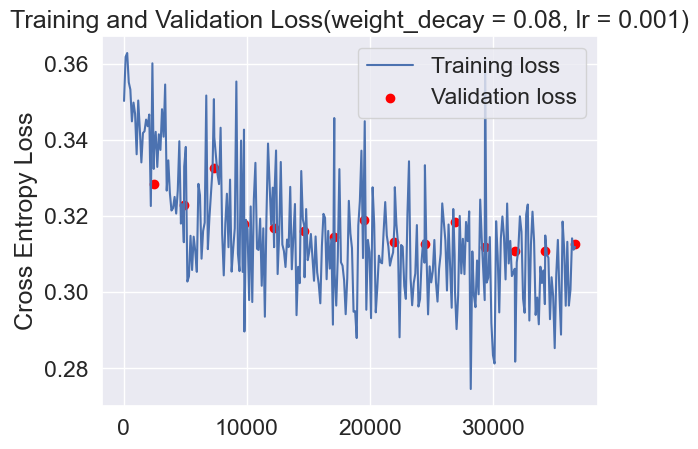

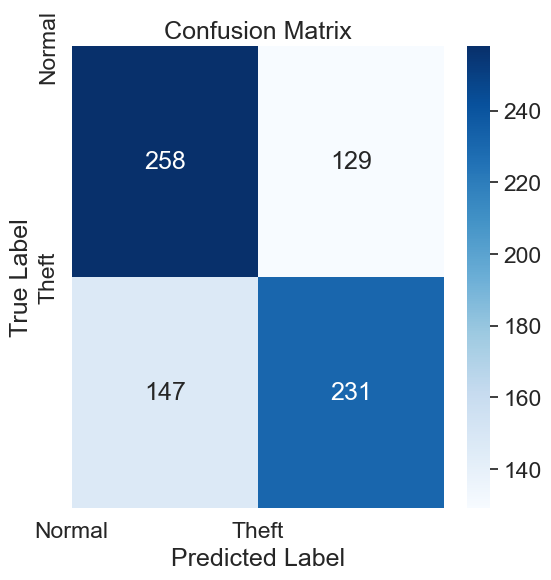

Recall: 0.6111
Precision: 0.6417
F1 Score: 0.6260
Accuracy: 0.6392


In [40]:
# Again, train the model with best hyper parameters (Weight decay = 0.08, lr = 0.001)
lr_rate = 0.001
moment = 0.9
weight_dec = 0.08
num_of_epoch = 15
batch_size = 32
logging_period = 4

model =  models.vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

train(model, tr, val, batch_size, lr_rate, moment, weight_dec, num_of_epoch, logging_period)

# Test the model with the best hyper parameters
test(model, ts, batch_size)
